# Effects of Framing Styles in Physical Activity Intervention
## Thalia Viranda, Katara Zhiduo Xie, Melissa Tan


This document contains our data cleaning and preprocessing steps. 


In [1]:
import os
import importlib
import subprocess
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

# Set working directory - CHANGE THIS TO YOUR PATH
main_dir = "/Users/zhiduokatara/Cornell Tech/Fall24/ORIE 5160_Stats for DS/ORIE-5160-midterm-project"
data_dir = os.path.join(main_dir, "data/")
figure_dir = os.path.join(main_dir, "figure/")

# Change the current working directory
os.chdir(main_dir)  

# Load packages
# Define a list of package names
packages = ["pandas", "numpy", "matplotlib", "seaborn", "statsmodels", "datetime"]

# Function to install and import packages
for pkg in packages:
    try:
        importlib.import_module(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        globals()[pkg] = importlib.import_module(pkg)

/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_28713/2443663403.py:5: DtypeWarning: Columns (21,22,38,39,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  suggestions_dat = pd.read_csv(os.path.join(data_dir, "suggestions.csv"))
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


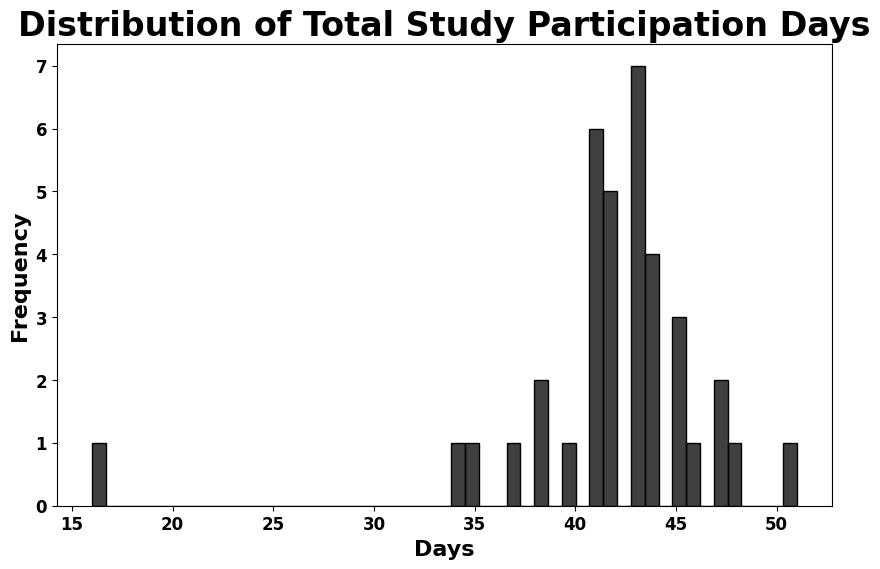

In [2]:
# Read CSV files
steps_gf = pd.read_csv(os.path.join(data_dir, "gfsteps.csv"))
steps_jb = pd.read_csv(os.path.join(data_dir, "jbsteps.csv"))
users_info = pd.read_csv(os.path.join(data_dir, "users.csv"))
suggestions_dat = pd.read_csv(os.path.join(data_dir, "suggestions.csv"))


# Assuming `users_info` DataFrame is already loaded
# Select specific columns
mydata_qs = users_info.filter(regex="user.index|totaldays|^selfeff")


# Reverse Scoring and Summed Variables
mydata_qs = mydata_qs.assign(
    selfeff_badmood_intake_r = 6 - mydata_qs["selfeff.badmood.intake"],
    selfeff_notime_intake_r = 6 - mydata_qs["selfeff.notime.intake"],
    selfeff_tired_intake_r = 6 - mydata_qs["selfeff.tired.intake"],
    selfeff_vaca_intake_r = 6 - mydata_qs["selfeff.vaca.intake"],
    selfeff_precip_intake_r = 6 - mydata_qs["selfeff.precip.intake"],
    
    # Summing intake reverse-scored values
    selfeff_intake_r = lambda x: (
        x["selfeff_notime_intake_r"] + x["selfeff_tired_intake_r"] +
        x["selfeff_vaca_intake_r"] + x["selfeff_precip_intake_r"] +
        x["selfeff_badmood_intake_r"]
    ),

    selfeff_badmood_exit_r = 6 - mydata_qs["selfeff.badmood.exit"],
    selfeff_notime_exit_r = 6 - mydata_qs["selfeff.notime.exit"],
    selfeff_tired_exit_r = 6 - mydata_qs["selfeff.tired.exit"],
    selfeff_vaca_exit_r = 6 - mydata_qs["selfeff.vaca.exit"],
    selfeff_precip_exit_r = 6 - mydata_qs["selfeff.precip.exit"],

    # Summing exit reverse-scored values
    selfeff_exit_r = lambda x: (
        x["selfeff_notime_exit_r"] + x["selfeff_tired_exit_r"] +
        x["selfeff_vaca_exit_r"] + x["selfeff_precip_exit_r"] +
        x["selfeff_badmood_exit_r"]
    )
)


# Histogram of Total Days
plt.figure(figsize=(10, 6))
sns.histplot(mydata_qs['totaldays'], bins=51, color="black", edgecolor="black")
plt.title("Distribution of Total Study Participation Days", fontsize=24, fontweight="bold")
plt.xlabel("Days", fontsize=16, fontweight="bold")
plt.ylabel("Frequency", fontsize=16, fontweight="bold")
plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
# plt.gca().set_facecolor("transparent")
plt.savefig(os.path.join(figure_dir,"hist_totalday.png"), transparent=True)
plt.show()

# Creating Notification Type Data
notif_type = suggestions_dat[['user.index', 'decision.index', 'decision.index.nogap', 'send', 'send.active', 'send.sedentary', 'gfsteps30', 'gfsteps60']] 


# Merging Data
steps_notif = pd.merge(steps_gf, notif_type, left_on=['user.index', 'decision.index'], right_on=['user.index', 'decision.index'], how='inner')


count    196734.000000
mean         27.095804
std          88.395718
min           1.000000
25%           1.000000
50%           4.000000
75%          27.000000
max        4929.000000
Name: steps, dtype: float64
Unique users in clean_steps_notif_users: 25
Unique users in mydata_steps_gf: 25


/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


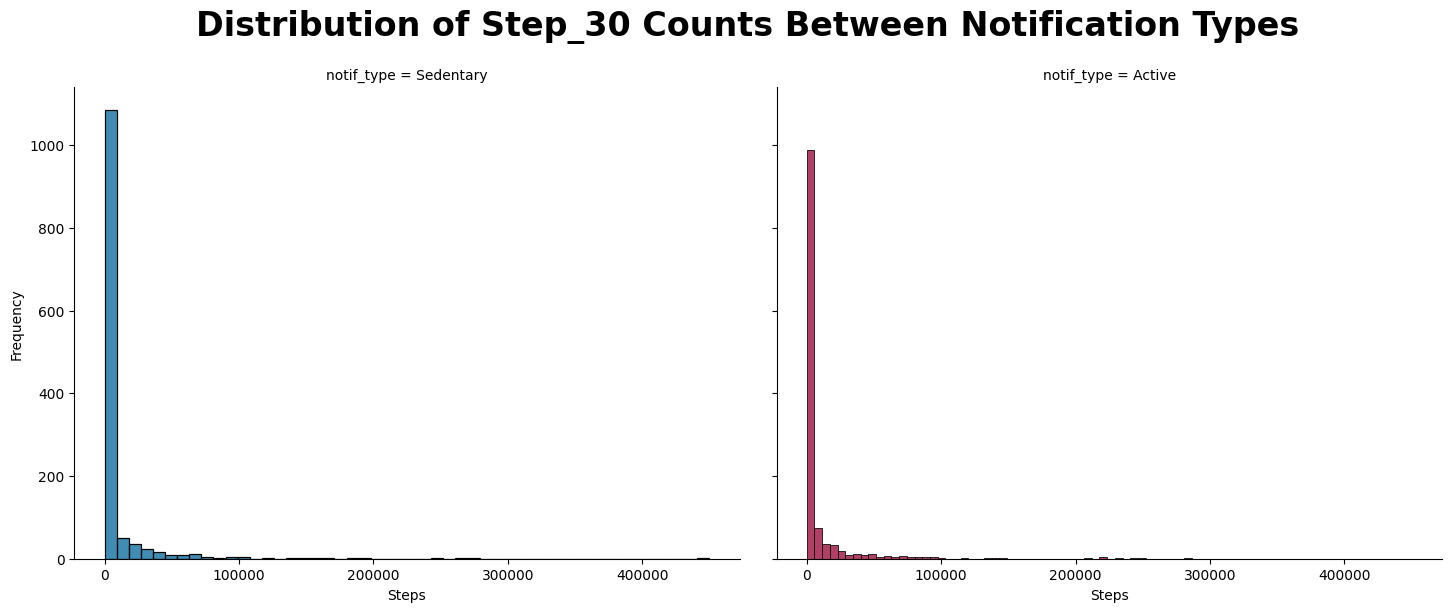

In [13]:

steps_notif_users = pd.merge(steps_notif, mydata_qs, on='user.index', how='inner')

# Converting columns to boolean
steps_notif_users['send'] = steps_notif_users['send'].astype(bool)
steps_notif_users['send.active'] = steps_notif_users['send.active'].astype(bool)

# Sorting and modifying user.index
steps_notif_users = steps_notif_users.sort_values(by='steps.utime')
steps_notif_users['user.index'] = pd.to_numeric(steps_notif_users['user.index'], errors='coerce')

steps_notif_users = (
    steps_notif_users
    .sort_values(by=['user.index', 'steps.utime', 'decision.index.nogap'])
)

# Summary Statistics
steps_summary = steps_notif_users['steps'].describe()
print(steps_summary)

# Exporting Data to CSV
steps_notif_users.to_csv(os.path.join(data_dir, "steps_notif_users_py.csv"), index=False)


# # Function to handle missing data in 'steps' column using LOCF
# def handle_missing_steps_locf(data):
#     data['steps'] = data['steps'].fillna(method='ffill')
#     return data

# # Apply LOCF to steps column
# steps_notif_users = handle_missing_steps_locf(steps_notif_users)

# Filter and transform steps_notif_users
clean_steps_notif_users = (
    steps_notif_users
    # .loc[(steps_notif_users['send'] == True) & (~steps_notif_users['user.index'].isin([29, 22])) & (~steps_notif_users['decision.index.nogap'].isna())]  # Filtering for send == True and excluding users 29 and 22 and those with missing decision index
    .loc[(steps_notif_users['send'] == True) & (~steps_notif_users['user.index'].isin([29, 22]))] 
    .dropna(subset=['steps.utime','decision.index.nogap'])  # Ensure steps.utime is not NA
    .assign(
        notif_type=lambda x: x['send.active'].apply(lambda y: "Active" if y else "Sedentary"),
        steps_date=lambda x: pd.to_datetime(x['steps.utime']).dt.date
    )
    .dropna(subset=['notif_type'])  # Ensure notif_type is not NA
    .sort_values(by=['user.index', 'steps.utime', 'decision.index.nogap'])
    .assign(
        day=lambda x: x.groupby('user.index')['steps_date'].transform(lambda y: pd.factorize(y)[0] + 1)
    )
)


# Summary statistics, filtering, and transformations for mydata_steps_gf
mydata_steps_gf = (
    clean_steps_notif_users
    .loc[:, ['user.index', 'steps_date', 'day', 'notif_type', 'decision.index.nogap','selfeff_intake_r',  'steps', 'gfsteps30', 'gfsteps60']]
    .groupby(['user.index', 'day', 'notif_type', 'decision.index.nogap', 'selfeff_intake_r'], as_index=False)
    .agg(
        n_total=('steps', 'size'),
        n_30=('gfsteps30', 'size'),
        n_60=('gfsteps60', 'size'),
        total_steps=('steps', 'sum'),
        steps_30=('gfsteps30', 'sum'),
        steps_60=('gfsteps60', 'sum'),
    )
    #.dropna(subset=['total_steps'])  # Filter rows where total_steps is NA
    .sort_values(by=['user.index', 'decision.index.nogap']
))



# View the count of unique users in clean_steps_notif_users and mydata_steps_gf
unique_user_count_clean = clean_steps_notif_users['user.index'].nunique()
unique_user_count_mydata = mydata_steps_gf['user.index'].nunique()

print(f"Unique users in clean_steps_notif_users: {unique_user_count_clean}")
print(f"Unique users in mydata_steps_gf: {unique_user_count_mydata}")

# Exporting Data to CSV
mydata_steps_gf.to_csv(os.path.join(data_dir, "mydata_steps_gf_py.csv"), index=False)

# STEP 1: Check for Normality (Histogram)
# Set up the FacetGrid with 'notif_type' as the facet variable
mypalette = {"Active": "#006699", "Sedentary": "#990033"}
g = sns.FacetGrid(mydata_steps_gf, col="notif_type", height=6, aspect=1.2, sharex=True, sharey=True, palette=mypalette)
# Map sns.histplot to each facet, using the color for each 'notif_type'
for ax, (notif_type, color) in zip(g.axes.flat, mypalette.items()):
    sns.histplot(
        data=mydata_steps_gf[mydata_steps_gf['notif_type'] == notif_type],
        x="steps_30", bins=50, color=color, edgecolor="black", ax=ax     # changed to plotting step_30 instead of total steps
    )

g.figure.suptitle("Distribution of Step_30 Counts Between Notification Types", fontsize=24, weight='bold')
g.set_axis_labels("Steps", "Frequency")
plt.subplots_adjust(top=0.85)
# Save the facet-wrapped plot with a transparent background
g.savefig(os.path.join(figure_dir,"steps_30_dist_faceted.png"), transparent=True)
plt.show()



In [16]:
# Plot for steps_60
# Map sns.histplot to each facet, using the color for each 'notif_type'
for ax, (notif_type, color) in zip(g.axes.flat, mypalette.items()):
    sns.histplot(
        data=mydata_steps_gf[mydata_steps_gf['notif_type'] == notif_type],
        x="steps_60", bins=50, color=color, edgecolor="black", ax=ax     # changed to plotting step_60 instead of total steps
    )

g.figure.suptitle("Distribution of Step_60 Counts Between Notification Types", fontsize=24, weight='bold')
g.set_axis_labels("Steps", "Frequency")
plt.subplots_adjust(top=0.85)
# Save the facet-wrapped plot with a transparent background
g.savefig(os.path.join(figure_dir,"steps_60_dist_faceted.png"), transparent=True)
plt.show()

/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 640x480 with 0 Axes>

In [17]:


# STEP 2: Check for Overdispersion (Summary Statistics)
# Melt data to long format (similar to `gather`)
melted_data = pd.melt(
    clean_steps_notif_users, 
    id_vars=['notif_type'], 
    value_vars=['steps', 'selfeff_intake_r'],
    var_name='key', 
    value_name='value'
)

# Group by and calculate summary statistics
SUMM_mydata_steps_gf = (
    melted_data
    .groupby(['notif_type', 'key'])
    .agg(
        n=('value', 'size'),
        mean=('value', lambda x: round(np.mean(x.dropna()), 1)),
        var=('value', lambda x: round(np.var(x.dropna()), 1)),
        sd=('value', lambda x: round(np.std(x.dropna()), 1)),
        se=('value', lambda x: round(np.std(x.dropna()) / np.sqrt(x.notna().sum()), 1)),
        median=('value', lambda x: round(np.median(x.dropna()), 1)),
        IQR=('value', lambda x: round(np.percentile(x.dropna(), 75) - np.percentile(x.dropna(), 25), 1))
    )
).reset_index()

# Display summary statistics
print(SUMM_mydata_steps_gf)


  notif_type               key      n  mean     var    sd   se  median   IQR
0     Active  selfeff_intake_r  46478  15.0    12.4   3.5  0.0    15.0   5.0
1     Active             steps  46478  27.0  6720.1  82.0  0.4     4.0  27.0
2  Sedentary  selfeff_intake_r  42490  14.8    14.2   3.8  0.0    15.0   5.0
3  Sedentary             steps  42490  29.2  9407.0  97.0  0.5     4.0  28.0


# EDA (need to be moved to a different file later to follow the PCS framework)


## RQ 1a: Effects of Framing Styles on Step Counts

Let's do: 
- between notifications/decision index (what we did for presentation); so the models will be: 
    - GF: 
        - total steps ~ notif_type (i.e., notif_type predicting total steps)
        - 30 after ~ notif_type
        - 60 after ~ notif_type

    - JAWBONE: 
        - total steps ~ notif_type
        - 30 after ~ notif_type
        - 60 after ~ notif_type
    
- to do the analyses for the steps 30 and 60 min after the notification is sent for both GF AND and Jawbone data, we need to do the following data preprocessing
    - get total step counts 30 min and 60 min after the notification for GF and Jaw bone
    - replaced the total_steps in the model with these two variables  


P.S. KATARA, I feel like we should turn each of these into a function since we are repeating the same analyses for the different *dependent variables (total steps between notifs, 30min after notif, 60 min after notif)* and the different *datasets (GF, Jawbone)*. 

What do you think?



                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      total_steps 
No. Observations:       2512         Method:                  REML        
No. Groups:             25           Scale:                   1641967.9051
Min. group size:        23           Log-Likelihood:          -21562.2111 
Max. group size:        134          Converged:               Yes         
Mean group size:        100.5                                             
--------------------------------------------------------------------------
                          Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
--------------------------------------------------------------------------
Intercept                  964.193  106.298  9.071 0.000  755.853 1172.534
notif_type[T.Sedentary]    -24.220   52.029 -0.466 0.642 -126.195   77.756
Group Var               247491.769   59.720                               



/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_28713/2726064955.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predictions_summary = mydata_steps_gf_30_60.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


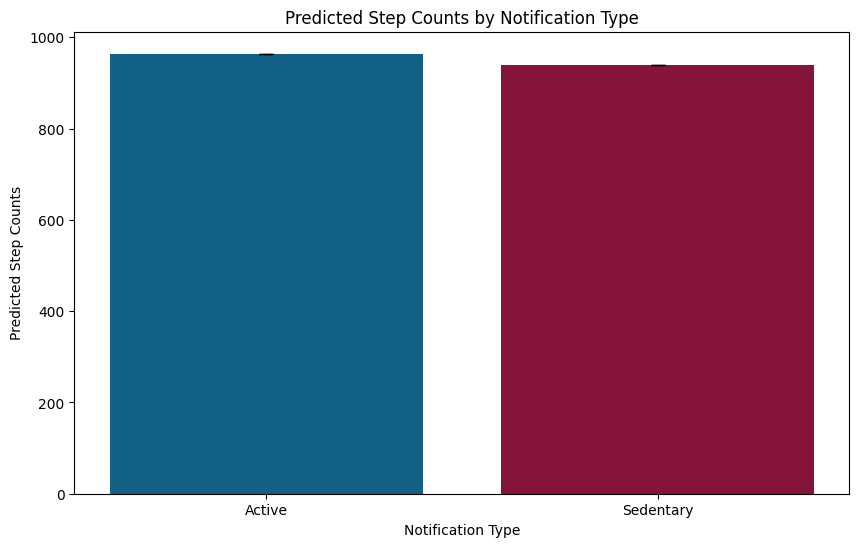

/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_28713/2726064955.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_summary = mydata_steps_gf_30_60.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


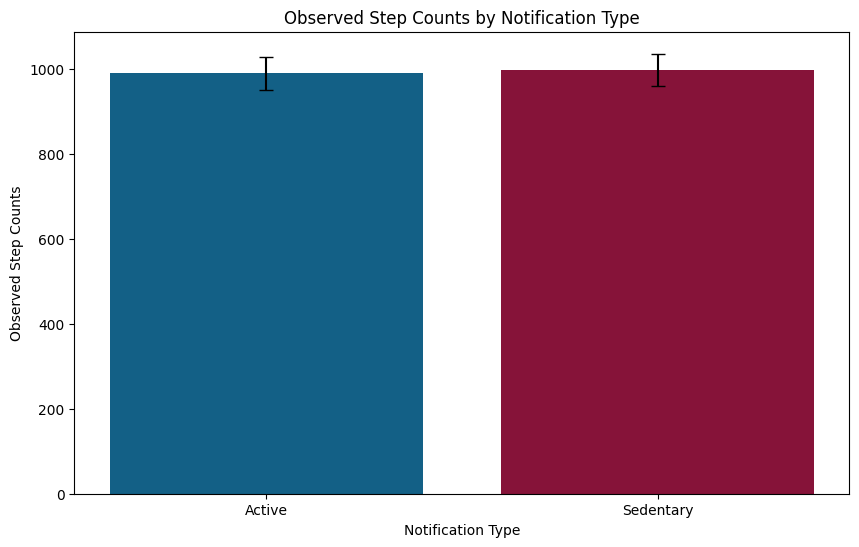

In [18]:
#====================================================================
# RQ 1: Effects of Framing Styles on Step Counts
# GF DATA: total between notif, 30min post notif, 60min post notif
#====================================================================

# load data
# mydata_steps_gf <- pd.read_csv(os.path.join(data_dir, "mydata_steps_gf_py.csv"))
mydata_steps_gf['user.index'] = mydata_steps_gf['user.index'].astype(str).astype('category')
mydata_steps_gf['notif_type'] = mydata_steps_gf['notif_type'].astype('category')

mydata_steps_gf_30_60 = mydata_steps_gf

from statsmodels.formula.api import mixedlm

#====================================================================
# GF DATA: total between notif (total_steps)
#====================================================================
# Define the model and fit (approximate approach using MixedLM)
model_nb_glmm = mixedlm("total_steps ~ notif_type", mydata_steps_gf_30_60, groups=mydata_steps_gf_30_60["user.index"])
result = model_nb_glmm.fit()
print(result.summary())

# Add predicted values into dataframe and 
# Create a summary of predicted values for plotting
mydata_steps_gf_30_60['predicted_steps'] = result.predict()
predictions_summary = mydata_steps_gf_30_60.groupby('notif_type').agg(
    mean_pred=('predicted_steps', 'mean'),
    lower_ci=('predicted_steps', lambda x: np.quantile(x, 0.025)),
    upper_ci=('predicted_steps', lambda x: np.quantile(x, 0.975)),
    se_pred=('predicted_steps', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# plot PREDICTED values 
plt.figure(figsize=(10, 6))
sns.barplot(data=predictions_summary, x="notif_type", y="mean_pred", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(predictions_summary['notif_type'], predictions_summary['mean_pred'], 
             yerr=predictions_summary['se_pred'], fmt='none', color='black', capsize=5)
plt.title("Predicted Step Counts by Notification Type")
plt.xlabel("Notification Type")
plt.ylabel("Predicted Step Counts")
plt.savefig(os.path.join(figure_dir, "pred_rq1.png"), transparent=True)
plt.show()

# Add OBSERVED values into dataframe and create a summary for plotting
observed_summary = mydata_steps_gf_30_60.groupby('notif_type').agg(
    mean_obs=('total_steps', 'mean'),
    lower_ci=('total_steps', lambda x: np.quantile(x, 0.025)),
    upper_ci=('total_steps', lambda x: np.quantile(x, 0.975)),
    se_obs=('total_steps', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# plot OBSERVED values 
plt.figure(figsize=(10, 6))
sns.barplot(data=observed_summary, x="notif_type", y="mean_obs", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(observed_summary['notif_type'], observed_summary['mean_obs'], 
             yerr=observed_summary['se_obs'], fmt='none', color='black', capsize=5)
plt.title("Observed Step Counts by Notification Type")
plt.xlabel("Notification Type")
plt.ylabel("Observed Step Counts")
plt.savefig(os.path.join(figure_dir,"obs_rq1.png"), transparent=True)
plt.show()



# Start of analyses with the JAWBONE DATASET 


#====================================================================
# JAWBONE DATA: total between notif (total_steps)
#====================================================================
# we need to do the same thing as the steps we did above, but now for the steps 30-min post the notification


#====================================================================
# JAWBONE DATA: total steps 30 min after notif (total_steps_30)
#====================================================================
# we need to do the same thing as the steps we did above, but now for the steps 30-min post the notification


#====================================================================
# JAWBONE DATA: total steps 60 min after notif (total_steps_60)
#====================================================================
# we need to do the same thing as the steps we did above, but now for the steps 60-min post the notification

In [28]:
mydata_steps_gf_30_60

,user.index,day,notif_type,decision.index.nogap,selfeff_intake_r,n_total,n_30,n_60,total_steps,steps_30,steps_60,predicted_steps,predicted_steps_30,predicted_steps_60
1,1,1,Sedentary,0.0,11,23,23,23,948,21804.0,21804.0,939.973467,7915.782206,18701.784036
0,1,1,Active,1.0,11,31,31,31,421,0.0,0.0,964.193117,7084.598657,17079.527187
2,1,1,Sedentary,3.0,11,14,14,14,302,4522.0,15442.0,939.973467,7915.782206,18701.784036
5,1,2,Sedentary,3.0,11,59,59,59,1014,19057.0,65077.0,939.973467,7915.782206,18701.784036
6,1,2,Sedentary,5.0,11,4,4,4,11,8.0,44.0,939.973467,7915.782206,18701.784036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,30,31,Sedentary,196.0,12,2,2,2,17,0.0,0.0,939.973467,7915.782206,18701.784036
2508,30,31,Sedentary,197.0,12,18,18,18,174,1080.0,1278.0,939.973467,7915.782206,18701.784036
2509,30,32,Active,199.0,12,9,9,9,50,153.0,153.0,964.193117,7084.598657,17079.527187
2510,30,33,Active,203.0,12,5,5,5,22,65.0,65.0,964.193117,7084.598657,17079.527187


/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_28713/3891444719.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predictions_summary_30 = mydata_steps_gf_30_60.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


                   Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      steps_30      
No. Observations:       2512         Method:                  REML          
No. Groups:             25           Scale:                   690308432.6857
Min. group size:        23           Log-Likelihood:          -29130.7510   
Max. group size:        134          Converged:               Yes           
Mean group size:        100.5                                               
----------------------------------------------------------------------------
                           Coef.     Std.Err.   z   P>|z|   [0.025   0.975] 
----------------------------------------------------------------------------
Intercept                   7084.599 1324.617 5.348 0.000  4488.398 9680.800
notif_type[T.Sedentary]      831.184 1064.367 0.781 0.435 -1254.938 2917.305
Group Var               29381429.094  394.662                               



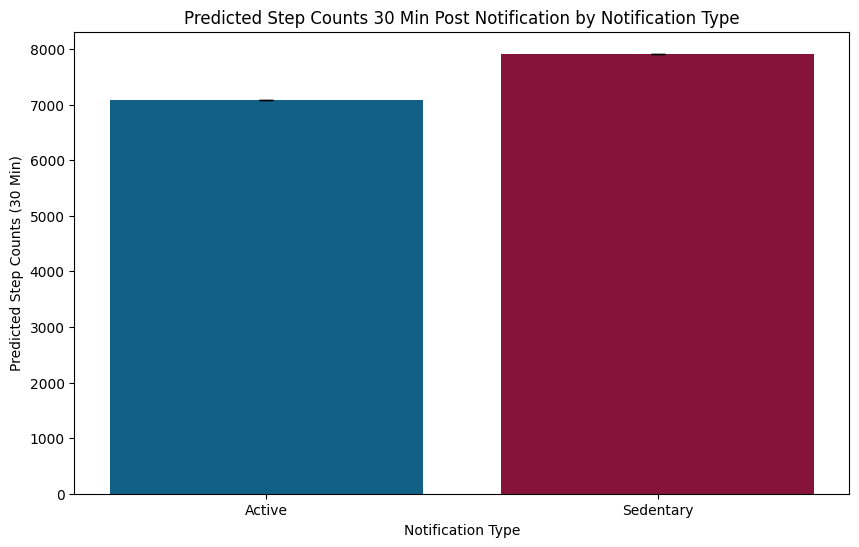

/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_28713/3891444719.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_summary_30 = mydata_steps_gf_30_60.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


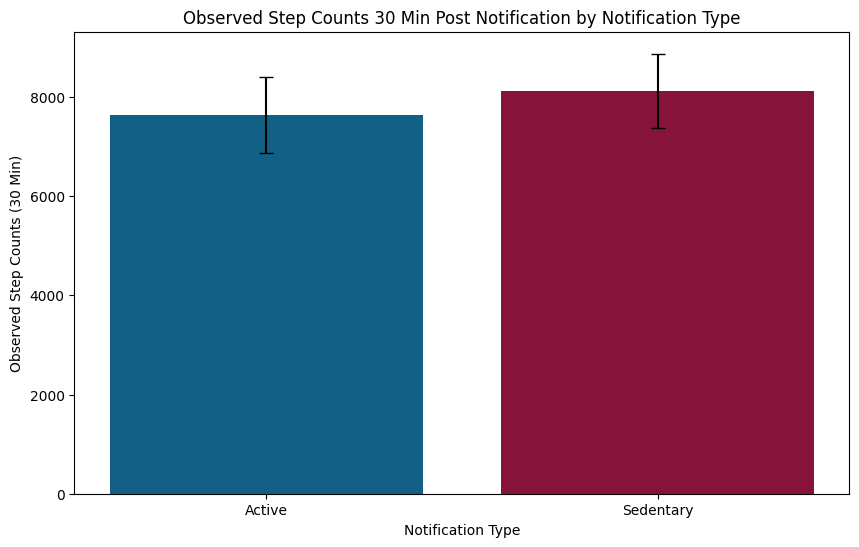

In [22]:

#====================================================================
# GF DATA: total steps 30 min after notif (gfsteps30)
#====================================================================
# we need to do the same thing as the steps we did above, but now for the steps 30-min post the notification
# print(mydata_steps_gf_30_60[['gfsteps30', 'notif_type', 'user.index']].isnull().sum())
# Filter out rows where 'gfsteps30' is NaN
# Filter out rows where 'gfsteps30' or 'gfsteps60' are NaN
# mydata_steps_gf_30_60 = mydata_steps_gf_30_60.dropna(subset=['gfsteps30', 'gfsteps60']).reset_index(drop=True)
mydata_steps_gf_30_60 = mydata_steps_gf

from statsmodels.formula.api import mixedlm

# Define the model and fit (approximate approach using MixedLM)
model_gf30_glmm = mixedlm("steps_30 ~ notif_type", mydata_steps_gf_30_60, groups=mydata_steps_gf_30_60["user.index"])
result_gf30 = model_gf30_glmm.fit()
print(result_gf30.summary())

# Add predicted values into dataframe and 
# Create a summary of predicted values for plotting
mydata_steps_gf_30_60['predicted_steps_30'] = result_gf30.predict()
predictions_summary_30 = mydata_steps_gf_30_60.groupby('notif_type').agg(
    mean_pred=('predicted_steps_30', 'mean'),
    lower_ci=('predicted_steps_30', lambda x: np.quantile(x, 0.025)),
    upper_ci=('predicted_steps_30', lambda x: np.quantile(x, 0.975)),
    se_pred=('predicted_steps_30', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# Plot PREDICTED values for gfsteps30
plt.figure(figsize=(10, 6))
sns.barplot(data=predictions_summary_30, x="notif_type", y="mean_pred", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(predictions_summary_30['notif_type'], predictions_summary_30['mean_pred'], 
             yerr=predictions_summary_30['se_pred'], fmt='none', color='black', capsize=5)
plt.title("Predicted Step Counts 30 Min Post Notification by Notification Type")
plt.xlabel("Notification Type")
plt.ylabel("Predicted Step Counts (30 Min)")
plt.savefig(os.path.join(figure_dir, "pred_rq1_30min.png"), transparent=True)
plt.show()

# Add OBSERVED values into dataframe and create a summary for plotting
observed_summary_30 = mydata_steps_gf_30_60.groupby('notif_type').agg(
    mean_obs=('steps_30', 'mean'),
    lower_ci=('steps_30', lambda x: np.quantile(x, 0.025)),
    upper_ci=('steps_30', lambda x: np.quantile(x, 0.975)),
    se_obs=('steps_30', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# Plot OBSERVED values for gfsteps30
plt.figure(figsize=(10, 6))
sns.barplot(data=observed_summary_30, x="notif_type", y="mean_obs", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(observed_summary_30['notif_type'], observed_summary_30['mean_obs'], 
             yerr=observed_summary_30['se_obs'], fmt='none', color='black', capsize=5)
plt.title("Observed Step Counts 30 Min Post Notification by Notification Type")
plt.xlabel("Notification Type")
plt.ylabel("Observed Step Counts (30 Min)")
plt.savefig(os.path.join(figure_dir, "obs_rq1_30min.png"), transparent=True)
plt.show()


/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_28713/1710339072.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predictions_summary_60 = mydata_steps_gf_30_60.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


                    Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      steps_60       
No. Observations:        2512         Method:                  REML           
No. Groups:              25           Scale:                   3333251715.6267
Min. group size:         23           Log-Likelihood:          -31109.9912    
Max. group size:         134          Converged:               Yes            
Mean group size:         100.5                                                
------------------------------------------------------------------------------
                            Coef.     Std.Err.   z   P>|z|   [0.025    0.975] 
------------------------------------------------------------------------------
Intercept                   17079.527 3262.644 5.235 0.000 10684.863 23474.191
notif_type[T.Sedentary]      1622.257 2340.856 0.693 0.488 -2965.736  6210.250
Group Var               195818953.000 1139.841                           

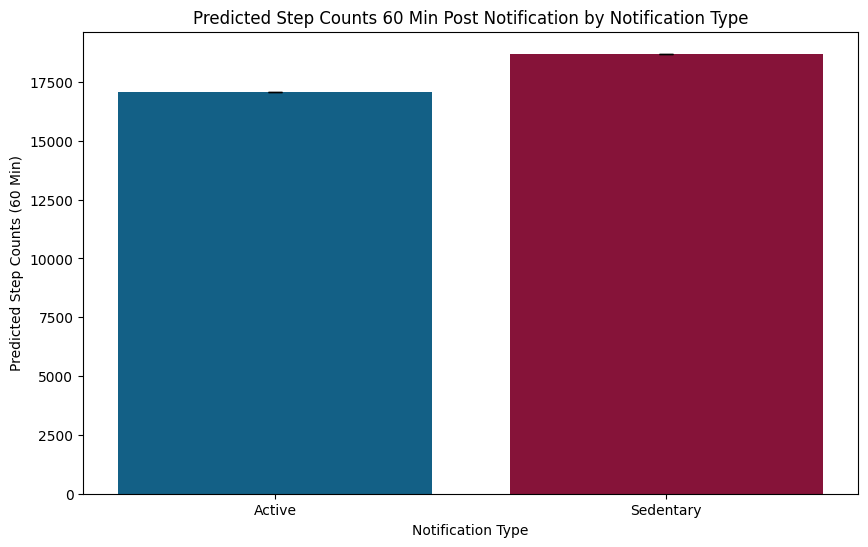

/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_28713/1710339072.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_summary_60 = mydata_steps_gf_30_60.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


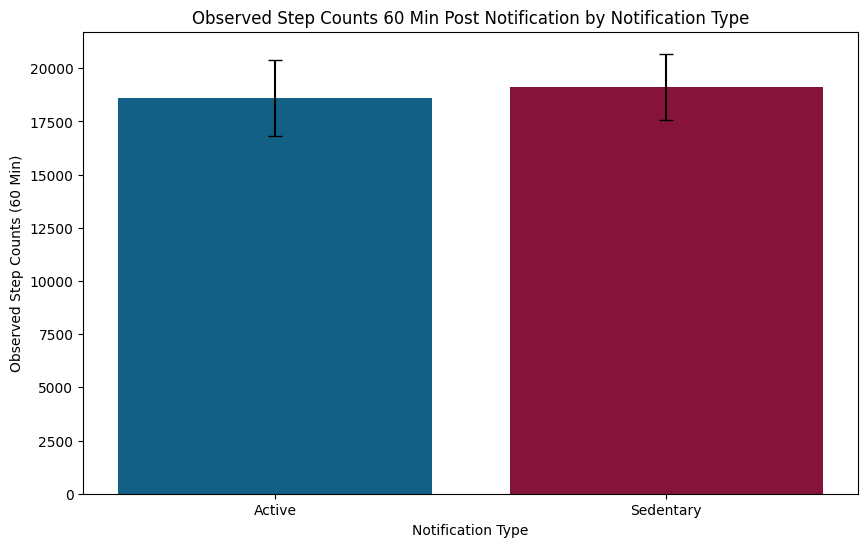

In [23]:

#====================================================================
# GF DATA: total steps 60 min after notif (gfsteps60)
#====================================================================
# we need to do the same thing as the steps we did above, but now for the steps 60-min post the notification

# Define the model and fit (approximate approach using MixedLM)
model_gf60_glmm = mixedlm("steps_60 ~ notif_type", mydata_steps_gf_30_60, groups=mydata_steps_gf_30_60["user.index"])
result_gf60 = model_gf60_glmm.fit()
print(result_gf60.summary())

# Add predicted values into dataframe and 
# Create a summary of predicted values for plotting
mydata_steps_gf_30_60['predicted_steps_60'] = result_gf60.predict()
predictions_summary_60 = mydata_steps_gf_30_60.groupby('notif_type').agg(
    mean_pred=('predicted_steps_60', 'mean'),
    lower_ci=('predicted_steps_60', lambda x: np.quantile(x, 0.025)),
    upper_ci=('predicted_steps_60', lambda x: np.quantile(x, 0.975)),
    se_pred=('predicted_steps_60', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# Plot PREDICTED values for gfsteps60
plt.figure(figsize=(10, 6))
sns.barplot(data=predictions_summary_60, x="notif_type", y="mean_pred", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(predictions_summary_60['notif_type'], predictions_summary_60['mean_pred'], 
             yerr=predictions_summary_60['se_pred'], fmt='none', color='black', capsize=5)
plt.title("Predicted Step Counts 60 Min Post Notification by Notification Type")
plt.xlabel("Notification Type")
plt.ylabel("Predicted Step Counts (60 Min)")
plt.savefig(os.path.join(figure_dir, "pred_rq1_60min.png"), transparent=True)
plt.show()

# Add OBSERVED values into dataframe and create a summary for plotting
observed_summary_60 = mydata_steps_gf_30_60.groupby('notif_type').agg(
    mean_obs=('steps_60', 'mean'),
    lower_ci=('steps_60', lambda x: np.quantile(x, 0.025)),
    upper_ci=('steps_60', lambda x: np.quantile(x, 0.975)),
    se_obs=('steps_60', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# Plot OBSERVED values for gfsteps60
plt.figure(figsize=(10, 6))
sns.barplot(data=observed_summary_60, x="notif_type", y="mean_obs", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(observed_summary_60['notif_type'], observed_summary_60['mean_obs'], 
             yerr=observed_summary_60['se_obs'], fmt='none', color='black', capsize=5)
plt.title("Observed Step Counts 60 Min Post Notification by Notification Type")
plt.xlabel("Notification Type")
plt.ylabel("Observed Step Counts (60 Min)")
plt.savefig(os.path.join(figure_dir, "obs_rq1_60min.png"), transparent=True)
plt.show()




## Log transformation on steps_30 and steps_60:

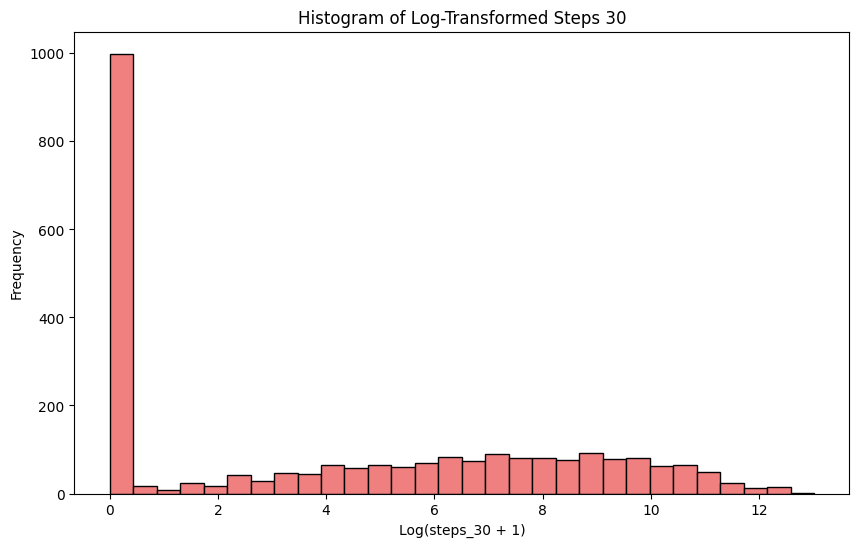

/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_28713/1449064667.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predictions_summary_log_30 = mydata_steps_gf_30_60_log.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)

              Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   log_steps_30
No. Observations:    2512      Method:               REML        
No. Groups:          25        Scale:                15.3969     
Min. group size:     23        Log-Likelihood:       -7022.5360  
Max. group size:     134       Converged:            Yes         
Mean group size:     100.5                                       
-----------------------------------------------------------------
                        Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               4.113    0.220 18.682 0.000  3.682  4.545
notif_type[T.Sedentary] 0.121    0.159  0.763 0.446 -0.190  0.433
Group Var               0.888    0.077                           



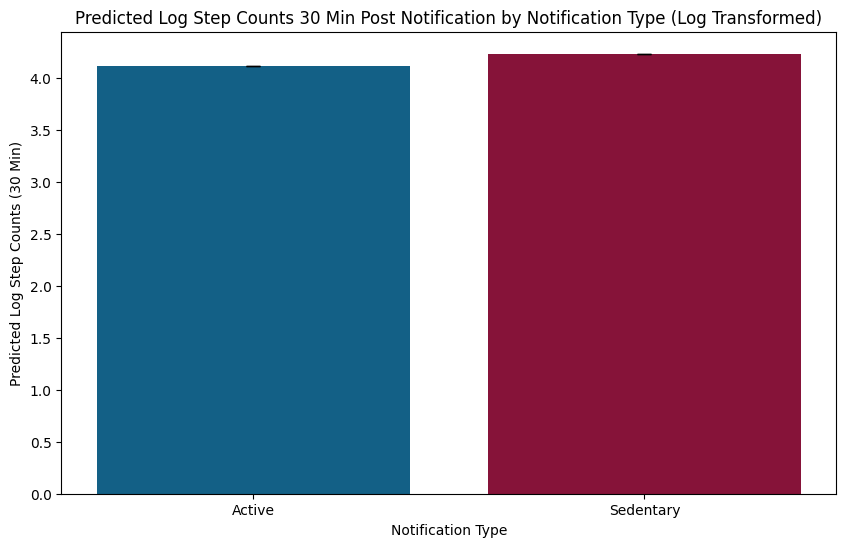

/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_28713/1449064667.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_summary_log_30 = mydata_steps_gf_30_60_log.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


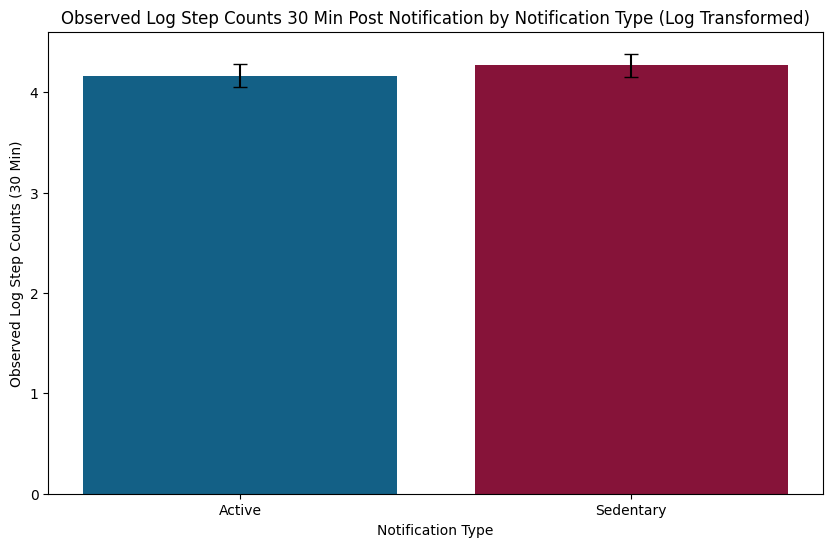

In [30]:
# Copy data and apply log transformation
mydata_steps_gf_30_60_log = mydata_steps_gf_30_60.copy()
mydata_steps_gf_30_60_log['log_steps_30'] = np.log1p(mydata_steps_gf_30_60_log['steps_30'])

# Plot histogram of the log-transformed `steps_30`
plt.figure(figsize=(10, 6))
plt.hist(mydata_steps_gf_30_60_log['log_steps_30'], bins=30, color='lightcoral', edgecolor='black')
plt.title("Histogram of Log-Transformed Steps 30")
plt.xlabel("Log(steps_30 + 1)")
plt.ylabel("Frequency")
plt.show()

# Define the model with log-transformed steps_30 and fit
model_gf30_glmm_log = mixedlm("log_steps_30 ~ notif_type", mydata_steps_gf_30_60_log, groups=mydata_steps_gf_30_60_log["user.index"])
result_gf30_log = model_gf30_glmm_log.fit()
print(result_gf30_log.summary())

# Add predicted values for the log-transformed model
mydata_steps_gf_30_60_log['predicted_log_steps_30'] = result_gf30_log.predict()
predictions_summary_log_30 = mydata_steps_gf_30_60_log.groupby('notif_type').agg(
    mean_pred_log=('predicted_log_steps_30', 'mean'),
    lower_ci_log=('predicted_log_steps_30', lambda x: np.quantile(x, 0.025)),
    upper_ci_log=('predicted_log_steps_30', lambda x: np.quantile(x, 0.975)),
    se_pred_log=('predicted_log_steps_30', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# Plot PREDICTED values for log-transformed gfsteps30
plt.figure(figsize=(10, 6))
sns.barplot(data=predictions_summary_log_30, x="notif_type", y="mean_pred_log", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(predictions_summary_log_30['notif_type'], predictions_summary_log_30['mean_pred_log'], 
             yerr=predictions_summary_log_30['se_pred_log'], fmt='none', color='black', capsize=5)
plt.title("Predicted Log Step Counts 30 Min Post Notification by Notification Type (Log Transformed)")
plt.xlabel("Notification Type")
plt.ylabel("Predicted Log Step Counts (30 Min)")
plt.savefig(os.path.join(figure_dir, "pred_log_rq1_30min.png"), transparent=True)
plt.show()

# Create summary of OBSERVED log-transformed values for plotting
observed_summary_log_30 = mydata_steps_gf_30_60_log.groupby('notif_type').agg(
    mean_obs_log=('log_steps_30', 'mean'),
    lower_ci_log=('log_steps_30', lambda x: np.quantile(x, 0.025)),
    upper_ci_log=('log_steps_30', lambda x: np.quantile(x, 0.975)),
    se_obs_log=('log_steps_30', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# Plot OBSERVED log-transformed values for gfsteps30
plt.figure(figsize=(10, 6))
sns.barplot(data=observed_summary_log_30, x="notif_type", y="mean_obs_log", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(observed_summary_log_30['notif_type'], observed_summary_log_30['mean_obs_log'], 
             yerr=observed_summary_log_30['se_obs_log'], fmt='none', color='black', capsize=5)
plt.title("Observed Log Step Counts 30 Min Post Notification by Notification Type (Log Transformed)")
plt.xlabel("Notification Type")
plt.ylabel("Observed Log Step Counts (30 Min)")
plt.savefig(os.path.join(figure_dir, "obs_log_rq1_30min.png"), transparent=True)
plt.show()

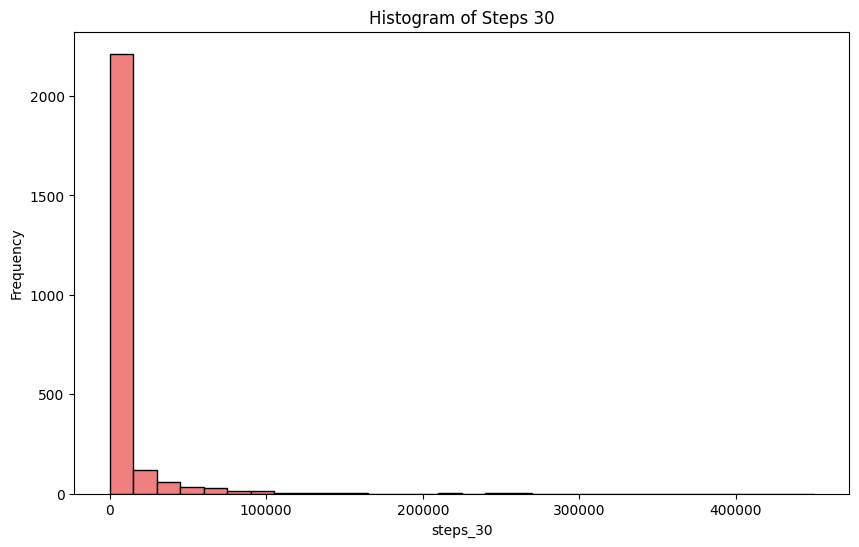

                 Generalized Linear Model Regression Results                  
Dep. Variable:               steps_30   No. Observations:                 2512
Model:                            GLM   Df Residuals:                     2510
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -25048.
Date:                Sun, 03 Nov 2024   Deviance:                       25926.
Time:                        17:00:05   Pearson chi2:                 2.93e+04
No. Iterations:                     7   Pseudo R-squ. (CS):          0.0009735
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_28713/909003585.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predictions_summary_nb_30 = mydata_steps_gf_30_60_nb.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


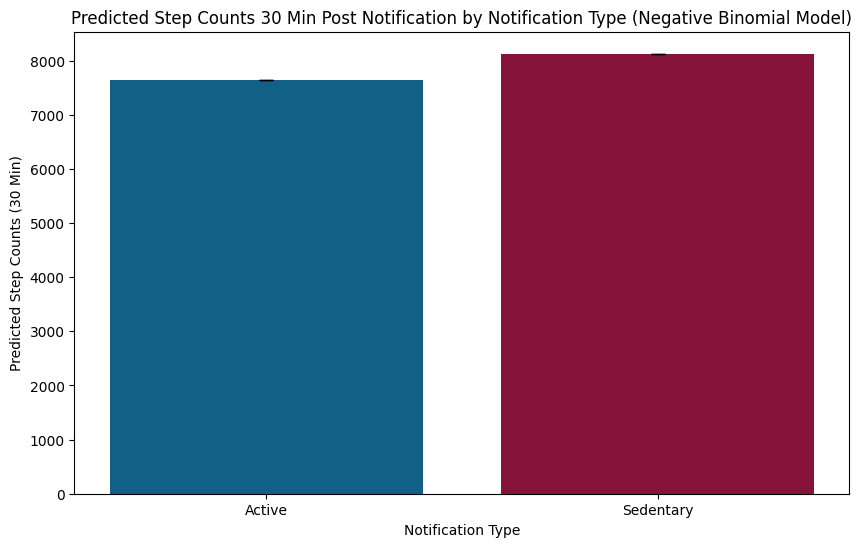

/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_28713/909003585.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_summary_nb_30 = mydata_steps_gf_30_60_nb.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


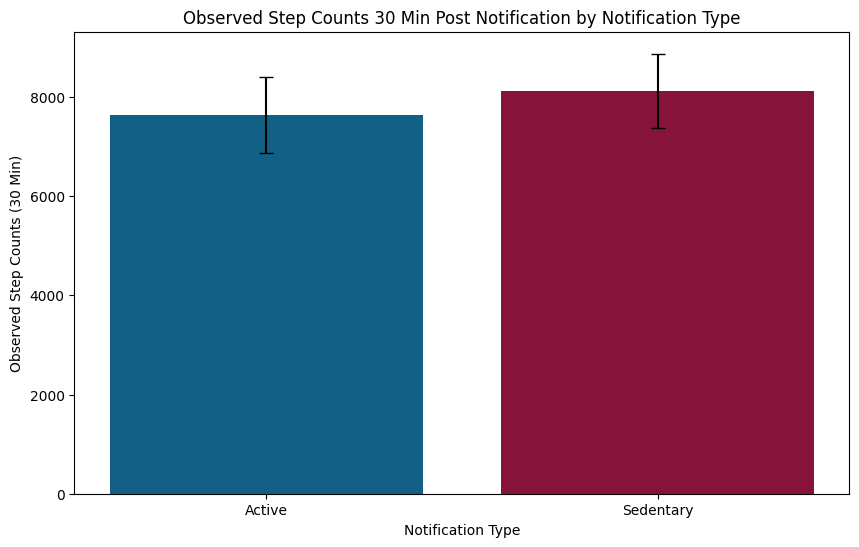

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.formula.api import glm
import statsmodels.api as sm

# Copy data (optional) for transformation
mydata_steps_gf_30_60_nb = mydata_steps_gf_30_60.copy()

# Plot histogram of the original `steps_30`
plt.figure(figsize=(10, 6))
plt.hist(mydata_steps_gf_30_60_nb['steps_30'], bins=30, color='lightcoral', edgecolor='black')
plt.title("Histogram of Steps 30")
plt.xlabel("steps_30")
plt.ylabel("Frequency")
plt.show()

# Define and fit the Negative Binomial GLM as an approximation for GLMM
model_gf30_nb_glmm = glm("steps_30 ~ notif_type", data=mydata_steps_gf_30_60_nb, 
                         family=sm.families.NegativeBinomial()).fit()
print(model_gf30_nb_glmm.summary())

# Add predicted values for Negative Binomial GLM model
mydata_steps_gf_30_60_nb['predicted_steps_30_nb'] = model_gf30_nb_glmm.predict()
predictions_summary_nb_30 = mydata_steps_gf_30_60_nb.groupby('notif_type').agg(
    mean_pred_nb=('predicted_steps_30_nb', 'mean'),
    lower_ci_nb=('predicted_steps_30_nb', lambda x: np.quantile(x, 0.025)),
    upper_ci_nb=('predicted_steps_30_nb', lambda x: np.quantile(x, 0.975)),
    se_pred_nb=('predicted_steps_30_nb', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# Plot PREDICTED values for steps_30 using Negative Binomial model
plt.figure(figsize=(10, 6))
sns.barplot(data=predictions_summary_nb_30, x="notif_type", y="mean_pred_nb", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(predictions_summary_nb_30['notif_type'], predictions_summary_nb_30['mean_pred_nb'], 
             yerr=predictions_summary_nb_30['se_pred_nb'], fmt='none', color='black', capsize=5)
plt.title("Predicted Step Counts 30 Min Post Notification by Notification Type (Negative Binomial Model)")
plt.xlabel("Notification Type")
plt.ylabel("Predicted Step Counts (30 Min)")
plt.savefig(os.path.join(figure_dir, "pred_nb_rq1_30min.png"), transparent=True)
plt.show()

# Create summary of OBSERVED values for plotting
observed_summary_nb_30 = mydata_steps_gf_30_60_nb.groupby('notif_type').agg(
    mean_obs=('steps_30', 'mean'),
    lower_ci=('steps_30', lambda x: np.quantile(x, 0.025)),
    upper_ci=('steps_30', lambda x: np.quantile(x, 0.975)),
    se_obs=('steps_30', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# Plot OBSERVED values for steps_30
plt.figure(figsize=(10, 6))
sns.barplot(data=observed_summary_nb_30, x="notif_type", y="mean_obs", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(observed_summary_nb_30['notif_type'], observed_summary_nb_30['mean_obs'], 
             yerr=observed_summary_nb_30['se_obs'], fmt='none', color='black', capsize=5)
plt.title("Observed Step Counts 30 Min Post Notification by Notification Type")
plt.xlabel("Notification Type")
plt.ylabel("Observed Step Counts (30 Min)")
plt.savefig(os.path.join(figure_dir, "obs_nb_rq1_30min.png"), transparent=True)
plt.show()


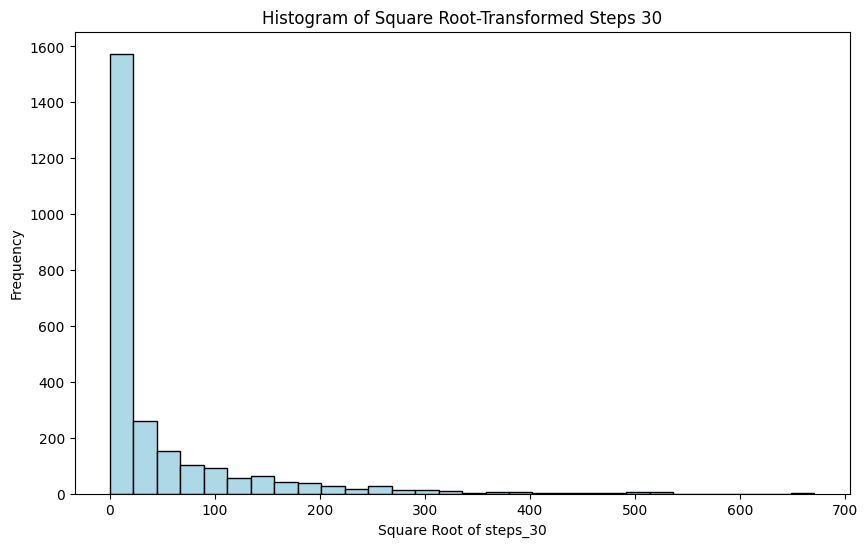

              Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   sqrt_steps_30
No. Observations:    2512      Method:               REML         
No. Groups:          25        Scale:                5630.0659    
Min. group size:     23        Log-Likelihood:       -14430.2570  
Max. group size:     134       Converged:            Yes          
Mean group size:     100.5                                        
------------------------------------------------------------------
                         Coef.  Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                40.113    4.382 9.155 0.000 31.525 48.701
notif_type[T.Sedentary]   3.747    3.042 1.232 0.218 -2.216  9.710
Group Var               361.242    1.600                          



/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import mixedlm

# Apply square root transformation to the `steps_30` column
mydata_steps_gf_30_60_sqrt = mydata_steps_gf_30_60.copy()
mydata_steps_gf_30_60_sqrt['sqrt_steps_30'] = np.sqrt(mydata_steps_gf_30_60_sqrt['steps_30'])

# Plot histogram of the square root-transformed `steps_30`
plt.figure(figsize=(10, 6))
plt.hist(mydata_steps_gf_30_60_sqrt['sqrt_steps_30'], bins=30, color='lightblue', edgecolor='black')
plt.title("Histogram of Square Root-Transformed Steps 30")
plt.xlabel("Square Root of steps_30")
plt.ylabel("Frequency")
plt.show()

# Define the model using the square root-transformed steps_30 and fit
model_gf30_sqrt_glmm = mixedlm("sqrt_steps_30 ~ notif_type", mydata_steps_gf_30_60_sqrt, groups=mydata_steps_gf_30_60_sqrt["user.index"])
result_gf30_sqrt = model_gf30_sqrt_glmm.fit()
print(result_gf30_sqrt.summary())


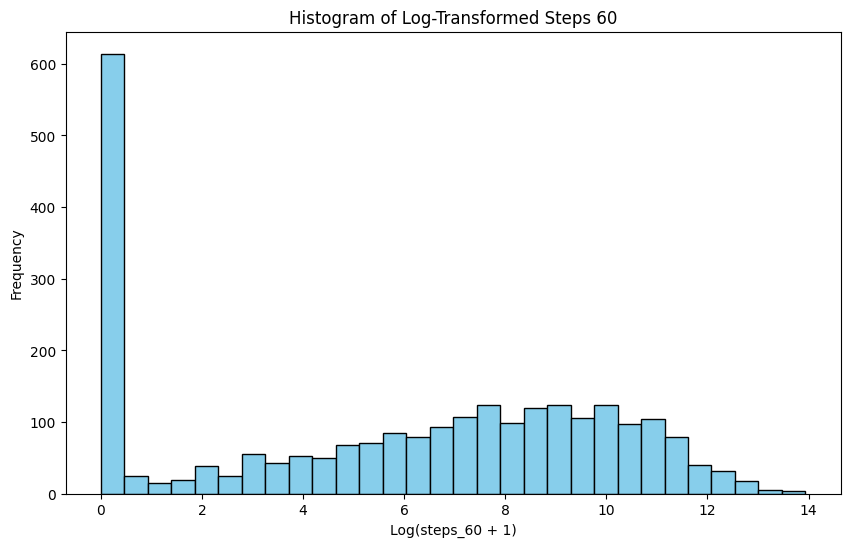

              Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   log_steps_60
No. Observations:    2512      Method:               REML        
No. Groups:          25        Scale:                15.3122     
Min. group size:     23        Log-Likelihood:       -7021.8087  
Max. group size:     134       Converged:            Yes         
Mean group size:     100.5                                       
-----------------------------------------------------------------
                        Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               5.587    0.277 20.148 0.000  5.044  6.131
notif_type[T.Sedentary] 0.243    0.159  1.532 0.125 -0.068  0.555
Group Var               1.598    0.130                           



/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_28713/823203347.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predictions_summary_log_60 = mydata_steps_gf_30_60_log.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


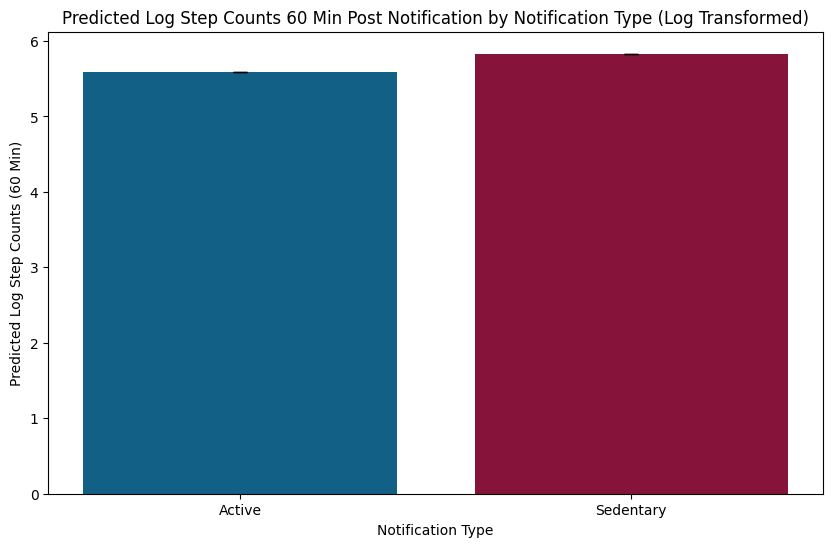

/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_28713/823203347.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_summary_log_60 = mydata_steps_gf_30_60_log.groupby('notif_type').agg(
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


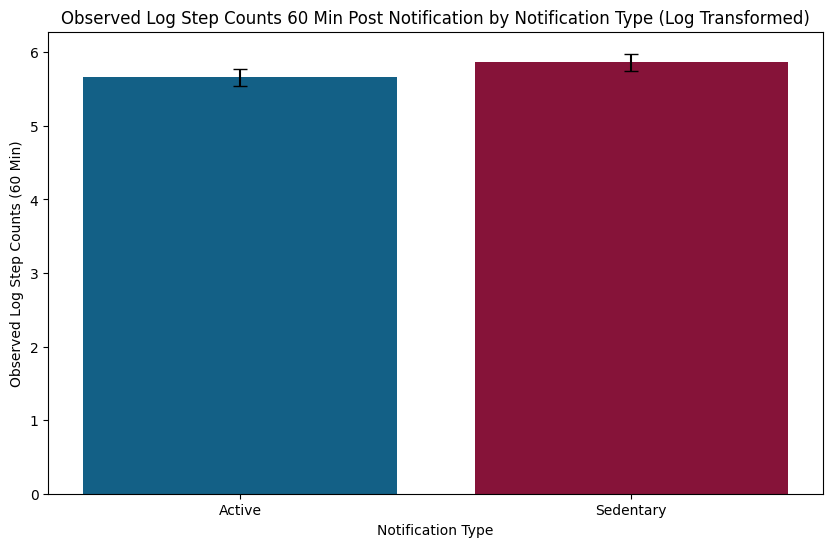

In [29]:
# Copy data and apply log transformation to steps_60
mydata_steps_gf_30_60_log = mydata_steps_gf_30_60.copy()
mydata_steps_gf_30_60_log['log_steps_60'] = np.log1p(mydata_steps_gf_30_60_log['steps_60'])

# Plot histogram of the log-transformed `steps_60`
plt.figure(figsize=(10, 6))
plt.hist(mydata_steps_gf_30_60_log['log_steps_60'], bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Log-Transformed Steps 60")
plt.xlabel("Log(steps_60 + 1)")
plt.ylabel("Frequency")
plt.show()

# Define the model with log-transformed steps_60 and fit
model_gf60_glmm_log = mixedlm("log_steps_60 ~ notif_type", mydata_steps_gf_30_60_log, groups=mydata_steps_gf_30_60_log["user.index"])
result_gf60_log = model_gf60_glmm_log.fit()
print(result_gf60_log.summary())

# Add predicted values for the log-transformed model
mydata_steps_gf_30_60_log['predicted_log_steps_60'] = result_gf60_log.predict()
predictions_summary_log_60 = mydata_steps_gf_30_60_log.groupby('notif_type').agg(
    mean_pred_log=('predicted_log_steps_60', 'mean'),
    lower_ci_log=('predicted_log_steps_60', lambda x: np.quantile(x, 0.025)),
    upper_ci_log=('predicted_log_steps_60', lambda x: np.quantile(x, 0.975)),
    se_pred_log=('predicted_log_steps_60', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# Plot PREDICTED values for log-transformed steps_60
plt.figure(figsize=(10, 6))
sns.barplot(data=predictions_summary_log_60, x="notif_type", y="mean_pred_log", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(predictions_summary_log_60['notif_type'], predictions_summary_log_60['mean_pred_log'], 
             yerr=predictions_summary_log_60['se_pred_log'], fmt='none', color='black', capsize=5)
plt.title("Predicted Log Step Counts 60 Min Post Notification by Notification Type (Log Transformed)")
plt.xlabel("Notification Type")
plt.ylabel("Predicted Log Step Counts (60 Min)")
plt.savefig(os.path.join(figure_dir, "pred_log_rq1_60min.png"), transparent=True)
plt.show()

# Create summary of OBSERVED log-transformed values for plotting
observed_summary_log_60 = mydata_steps_gf_30_60_log.groupby('notif_type').agg(
    mean_obs_log=('log_steps_60', 'mean'),
    lower_ci_log=('log_steps_60', lambda x: np.quantile(x, 0.025)),
    upper_ci_log=('log_steps_60', lambda x: np.quantile(x, 0.975)),
    se_obs_log=('log_steps_60', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# Plot OBSERVED log-transformed values for steps_60
plt.figure(figsize=(10, 6))
sns.barplot(data=observed_summary_log_60, x="notif_type", y="mean_obs_log", palette={"Active": "#006699", "Sedentary": "#990033"})
plt.errorbar(observed_summary_log_60['notif_type'], observed_summary_log_60['mean_obs_log'], 
             yerr=observed_summary_log_60['se_obs_log'], fmt='none', color='black', capsize=5)
plt.title("Observed Log Step Counts 60 Min Post Notification by Notification Type (Log Transformed)")
plt.xlabel("Notification Type")
plt.ylabel("Observed Log Step Counts (60 Min)")
plt.savefig(os.path.join(figure_dir, "obs_log_rq1_60min.png"), transparent=True)
plt.show()


## RQ 1b: Effects of Framing Styles * Self-Efficacy on Step Counts

For this, basically we want to add the interaction term between self_efficacy (as discrete variable: low, medium, and high) into the models above. 
- GF: 
    - total steps ~ notif_type * self_efficacy 
    - 30 after ~ notif_type * self_efficacy
    - 60 after ~ notif_type * self_efficacy

- JAWBONE: 
    - total steps ~ notif_type * self_efficacy 
    - 30 after ~ notif_type * self_efficacy
    - 60 after ~ notif_type * self_efficacy


0.25    12.0
0.50    16.0
0.75    18.0
Name: selfeff_intake_r, dtype: float64
  notif_type selfeff_category    n    mean      sd    se     IQR
0     Active              Low  377   892.8  1341.9  69.1   997.0
1     Active           Medium  499   949.4  1173.0  52.5  1273.5
2     Active             High  392  1137.0  1665.3  84.1  1462.5
3  Sedentary              Low  404   870.7  1385.4  68.9   938.8
4  Sedentary           Medium  412   973.6  1221.8  60.2  1333.5
5  Sedentary             High  428  1142.3  1430.8  69.2  1506.0
  notif_type selfeff_category    n     mean       sd      se     IQR
0     Active              Low  377  10131.7  30535.2  1572.6  3317.0
1     Active           Medium  499   7786.0  25635.0  1147.6  2106.0
2     Active             High  392   5041.6  26236.5  1325.1  1446.0
3  Sedentary              Low  404   9014.6  29895.8  1487.4  2778.0
4  Sedentary           Medium  412  10065.2  29648.8  1460.7  4815.0
5  Sedentary             High  428   5422.8  17274.2 

/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_28713/450325567.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['notif_type', 'selfeff_category'])
/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_28713/450325567.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['notif_type', 'selfeff_category'])
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/Users/zhiduokatara/anaconda3/lib/

                                Mixed Linear Model Regression Results
Model:                           MixedLM               Dependent Variable:               total_steps 
No. Observations:                2512                  Method:                           REML        
No. Groups:                      25                    Scale:                            1642714.7723
Min. group size:                 23                    Log-Likelihood:                   -21536.9059 
Max. group size:                 134                   Converged:                        Yes         
Mean group size:                 100.5                                                               
-----------------------------------------------------------------------------------------------------
                                                     Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------------------------------------------
Intercept   

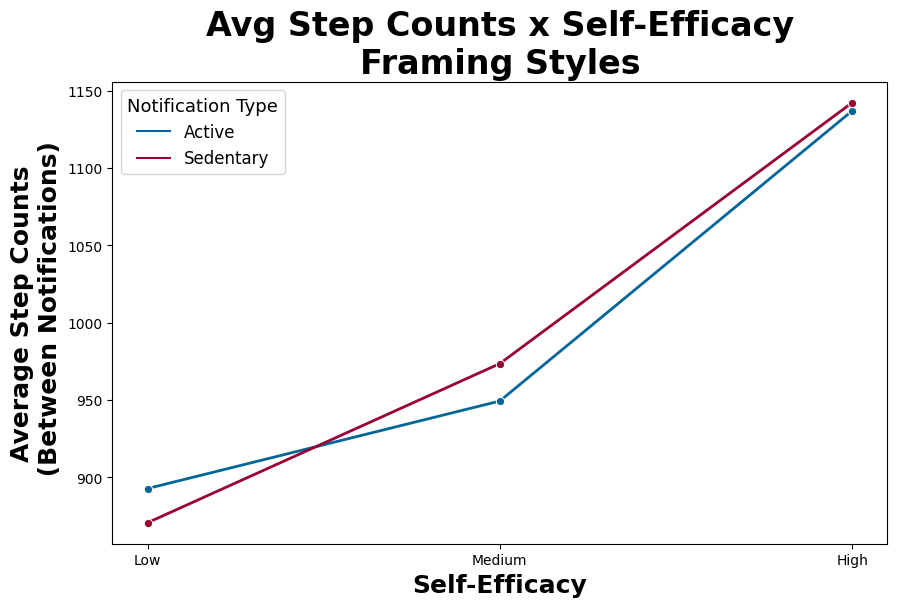

/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

                                  Mixed Linear Model Regression Results
Model:                            MixedLM                Dependent Variable:                steps_30      
No. Observations:                 2512                   Method:                            REML          
No. Groups:                       25                     Scale:                             690600916.7016
Min. group size:                  23                     Log-Likelihood:                    -29094.3003   
Max. group size:                  134                    Converged:                         Yes           
Mean group size:                  100.5                                                                   
----------------------------------------------------------------------------------------------------------
                                                      Coef.     Std.Err.   z    P>|z|   [0.025     0.975] 
------------------------------------------------------------------------

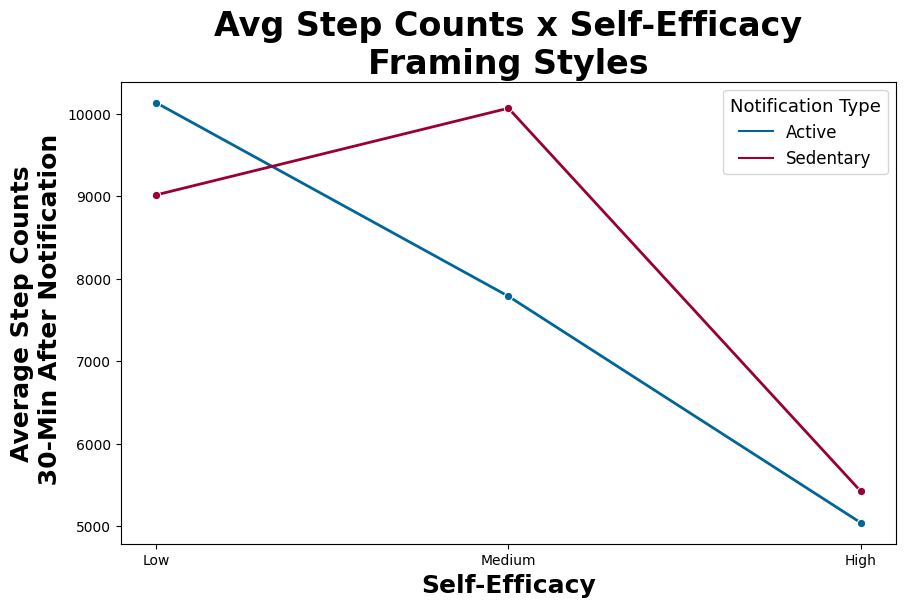

In [8]:
#====================================================================
# RQ 1b: Effects of Framing Styles * Self-Efficacy on Step Counts
# GF: total_steps between notif
#====================================================================

# load data
# mydata_steps_gf_30_60 <- pd.read_csv(os.path.join(data_dir, "mydata_steps_gf_py.csv"))
mydata_steps_gf_30_60['user.index'] = mydata_steps_gf_30_60['user.index'].astype('category')
mydata_steps_gf_30_60['notif_type'] = mydata_steps_gf_30_60['notif_type'].astype('category')

# Define self efficacy as a discrete variable based on its quantile
# low (<=13), med (14-17 inclusive), high (>=18)
selfeff_intake_quantiles = mydata_steps_gf_30_60['selfeff_intake_r'].quantile([0.25, 0.5, 0.75])
print(selfeff_intake_quantiles)

# Categorize selfeff.intake_r for visualization
# low (<=13), med (14-17 inclusive), high (>=18)
mydata_steps_gf_30_60['selfeff_category'] = pd.cut(
    mydata_steps_gf_30_60['selfeff_intake_r'], bins=[-np.inf, 14, 18, np.inf], labels=["Low", "Medium", "High"], right=False
)

# Create summary table
SUMM_mydata_steps_gf = (
    mydata_steps_gf_30_60
    .groupby(['notif_type', 'selfeff_category'])
    .agg(
        n=('total_steps', 'size'),
        mean=('total_steps', lambda x: round(np.mean(x), 1)),
        sd=('total_steps', lambda x: round(np.std(x), 1)),
        se=('total_steps', lambda x: round(np.std(x) / np.sqrt(x.notna().sum()), 1)),
        IQR=('total_steps', lambda x: round(np.percentile(x, 75) - np.percentile(x, 25), 1))
    )
    .reset_index()
)

print(SUMM_mydata_steps_gf)

# Create summary table
SUMM_mydata_steps_gf_30 = (
    mydata_steps_gf_30_60
    .groupby(['notif_type', 'selfeff_category'])
    .agg(
        n=('total_steps', 'size'),
        mean=('steps_30', lambda x: round(np.mean(x), 1)),
        sd=('steps_30', lambda x: round(np.std(x), 1)),
        se=('steps_30', lambda x: round(np.std(x) / np.sqrt(x.notna().sum()), 1)),
        IQR=('steps_30', lambda x: round(np.percentile(x, 75) - np.percentile(x, 25), 1))
    )
    .reset_index()
)

print(SUMM_mydata_steps_gf_30)


from statsmodels.formula.api import mixedlm
# Define the model and fit (approximate approach using MixedLM)
model_nb_glmm_notifxselfeff = mixedlm("total_steps ~ notif_type * selfeff_category", mydata_steps_gf_30_60, groups=mydata_steps_gf_30_60["user.index"])
result = model_nb_glmm_notifxselfeff.fit()
print(result.summary())


# Plot interaction effects (no interaction :( sadly)
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=SUMM_mydata_steps_gf, x="selfeff_category", y="mean", hue="notif_type", 
    marker="o", palette={"Active": "#006699", "Sedentary": "#990033"}, linewidth=2
)
plt.title("Avg Step Counts x Self-Efficacy\nFraming Styles", fontsize=24, fontweight='bold')
plt.xlabel("Self-Efficacy", fontsize=18, fontweight='bold')
plt.ylabel("Average Step Counts\n (Between Notifications)", fontsize=18, fontweight='bold')
plt.legend(title="Notification Type", fontsize=12, title_fontsize='13')

# Save the plot
plt.savefig(os.path.join(figure_dir,"notif_selfeff_steps_bwnotif.png"), transparent=True)
plt.show()


#====================================================================
# RQ 1b: Effects of Framing Styles * Self-Efficacy on Step Counts
# GF: total_steps 30 min after notif
#====================================================================
# Define the model and fit (approximate approach using MixedLM)
model_nb_glmm_notifxselfeff_30 = mixedlm("steps_30 ~ notif_type * selfeff_category", mydata_steps_gf_30_60, groups=mydata_steps_gf_30_60["user.index"])
result = model_nb_glmm_notifxselfeff_30.fit()
print(result.summary())


# Plot interaction effects (no interaction :( sadly)
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=SUMM_mydata_steps_gf_30, x="selfeff_category", y="mean", hue="notif_type", 
    marker="o", palette={"Active": "#006699", "Sedentary": "#990033"}, linewidth=2
)
plt.title("Avg Step Counts x Self-Efficacy\nFraming Styles", fontsize=24, fontweight='bold')
plt.xlabel("Self-Efficacy", fontsize=18, fontweight='bold')
plt.ylabel("Average Step Counts\n 30-Min After Notification", fontsize=18, fontweight='bold')
plt.legend(title="Notification Type", fontsize=12, title_fontsize='13')

# Save the plot
plt.savefig(os.path.join(figure_dir,"notif_selfeff_steps_bwnotif.png"), transparent=True)
plt.show()


#====================================================================
# RQ 1b: Effects of Framing Styles * Self-Efficacy on Step Counts
# GF: total_steps 60 min after notif
#====================================================================






# Start of analyses with the JAWBONE DATASET 



#====================================================================
# RQ 1b: Effects of Framing Styles * Self-Efficacy on Step Counts
# Jawbone: total_steps between notif
#====================================================================


#====================================================================
# RQ 1b: Effects of Framing Styles * Self-Efficacy on Step Counts
# Jawbone: total_steps 30 min after notif
#====================================================================


#====================================================================
# RQ 1b: Effects of Framing Styles * Self-Efficacy on Step Counts
# JawboneF: total_steps 60 min after notif
#====================================================================



## RQ 2a: Effects of Framing Styles on User Engagement (min between notif and first meaningful steps (at least 60steps))


/var/folders/rb/s8fz0j0d7xq20qvk9cm9vf9m0000gp/T/ipykernel_28713/1581920954.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: pd.Series({
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhiduokatara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_i

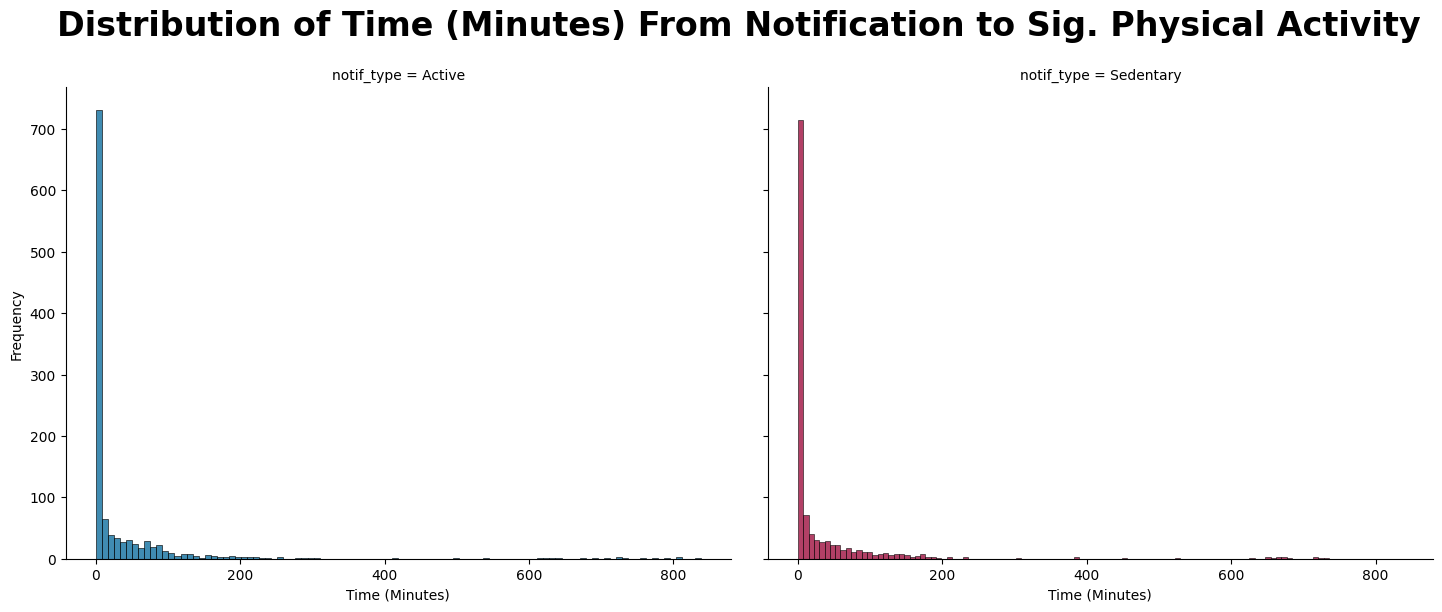

OSError: cannot load library '/Library/Frameworks/R.framework/Resources/lib/libR.dylib': dlopen(/Library/Frameworks/R.framework/Resources/lib/libR.dylib, 0x0002): tried: '/Library/Frameworks/R.framework/Resources/lib/libR.dylib' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Resources/lib/libR.dylib' (no such file), '/Library/Frameworks/R.framework/Resources/lib/libR.dylib' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/lib/libR.dylib' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/lib/libR.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/lib/libR.dylib' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64'))

In [9]:
# Convert `steps.utime` to datetime format and sort within each group
clean_steps_notif_users['steps.utime'] = pd.to_datetime(clean_steps_notif_users['steps.utime'])

# Group data and calculate time to significant activity (>= 60 steps)
ux_eng = (
    clean_steps_notif_users
    .sort_values(['user.index', 'decision.index', 'steps.utime'])
    .dropna(subset=['steps'])  # Filter out rows where 'steps' is NA since we are finding only time with steps
    .groupby(['user.index', 'decision.index', 'notif_type'])
    .apply(lambda df: pd.Series({
        'first_step_time': df['steps.utime'].iloc[0],
        'step_ge_60_time': df.loc[df['steps'] >= 60, 'steps.utime'].iloc[0] if not df.loc[df['steps'] >= 60].empty else np.nan,
        'selfeff_intake_r': df['selfeff_intake_r'].iloc[0]
    }))
    .reset_index()
)

ux_eng['user.index'] = ux_eng['user.index'].astype(str).astype('category')
ux_eng['notif_type'] = ux_eng['notif_type'].astype('category')

# Calculate time to step >= 60 in minutes and handle missing or zero values
ux_eng['time_to_step_ge_60'] = (ux_eng['step_ge_60_time'] - ux_eng['first_step_time']).dt.total_seconds() / 60
ux_eng['time_to_step_ge_60'] = ux_eng['time_to_step_ge_60'].fillna(0.01).round(2) #use 0.01 because GLMM only deals with positive values
ux_eng = ux_eng.sort_values(['user.index', 'decision.index'])



# Plot Faceted Histogram of Resp Time
# Set up the FacetGrid with 'notif_type' as the facet variable
mypalette = {"Active": "#006699", "Sedentary": "#990033"}
g = sns.FacetGrid(ux_eng, col="notif_type", height=6, aspect=1.2, sharex=True, sharey=True, palette=mypalette)
# Map sns.histplot to each facet, using the color for each 'notif_type'
for ax, (notif_type, color) in zip(g.axes.flat, mypalette.items()):
    sns.histplot(
        data=ux_eng[ux_eng['notif_type'] == notif_type],
        x="time_to_step_ge_60", bins=100, color=color, edgecolor="black", ax=ax
    )
g.figure.suptitle("Distribution of Time (Minutes) From Notification to Sig. Physical Activity", fontsize=24, weight='bold')
g.set_axis_labels("Time (Minutes)", "Frequency")
plt.subplots_adjust(top=0.85)
# Save the facet-wrapped plot with a transparent background
g.savefig(os.path.join(figure_dir,"resptime_faceted.png"), transparent=True)
plt.show()



from pymer4.models import Lmer
# Fit the model using pymer4 (requires R to be installed and accessible)
model_response_time = Lmer("time_to_step_ge_60 ~ notif_type + (1 | user.index)", data=ux_eng)
model_response_time.fit()
print(model_response_time.summary())


# Generate predictions on the original scale
# THIS SHOULD BE REVISITED. DO WE WANT TO SPLIT OUR DATASET INTO TRAINING VS. TEST within GF and within JAWBONE DATASET OR SHOULD WE USE GF DATA TO TRAIN AND TEST ON JAWBONE?
ux_eng['predicted_steps'] = model_response_time.predict(data=ux_eng, skip_data_checks=True, verify_predictions=False)


# Summarize predicted values by notification type
ux_predictions_summary = ux_eng.groupby('notif_type').agg(
    mean_pred=('predicted_steps', 'mean'),
    lower_ci=('predicted_steps', lambda x: np.quantile(x, 0.025)),
    upper_ci=('predicted_steps', lambda x: np.quantile(x, 0.975)),
    se_pred=('predicted_steps', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()


# Plot PREDICTED Response Time 
plt.figure(figsize=(10, 6))
sns.barplot(data=ux_predictions_summary, x="notif_type", y="mean_pred", palette={"Active": "#006699", "Sedentary": "#990033"}, edgecolor="black")
plt.errorbar(ux_predictions_summary['notif_type'], ux_predictions_summary['mean_pred'], 
             yerr=ux_predictions_summary['se_pred'], fmt='none', color='black', capsize=5)
plt.title("Predicted Response Time by Notification Type", fontsize=24, fontweight='bold')
plt.xlabel("Notification Type", fontsize=18, fontweight='bold')
plt.ylabel("Predicted Response Time (Mins)", fontsize=18, fontweight='bold')
plt.legend(title="Notification Type", fontsize=12, title_fontsize='13')

# Save plot
plt.savefig(os.path.join(figure_dir, "pred_rq2.png"), transparent=True)
plt.show()